<a href="https://colab.research.google.com/github/anuragprasad95/Portfolio_optimization/blob/main/Portfolio_optimization_to_boost_finance_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aim: Assume we have a portfolio full of risky assets. To find optimal portfolio which gives highest return with lowest risk.

Methodology: Sharpe Ratio = (Portfolio Return - Risk Free Rate)/Standard Deviation

In [93]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from datetime import datetime, timedelta

#1. Define Tickers and Time Range

Define the list of tickers

In [94]:
tickers = ['HDFCBANK.NS','SBIN.NS','FEDERALBNK.NS','ICICIBANK.NS','AXISBANK.NS']

Set the end date to today

In [95]:
end_date = datetime.today()

Set the start date to 5 years ago

In [96]:
start_date = end_date - timedelta(days = 5 * 365)
print(start_date)

2019-05-04 18:21:41.590221


#2. Download Adjusted Close Prices

Create an empty DataFrame to store the adjusted close prices

In [97]:
adj_close_df = pd.DataFrame()

Download the close prices for each ticker

In [98]:
for ticker in tickers:
  data = yf.download(ticker, start = start_date, end = end_date)
  adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Display the DataFrame

In [99]:
print(adj_close_df)

            HDFCBANK.NS     SBIN.NS  FEDERALBNK.NS  ICICIBANK.NS  AXISBANK.NS
Date                                                                         
2019-05-06  1123.394897  295.482605      95.568665    393.532898   744.628479
2019-05-07  1120.451782  292.324463      94.232040    379.019348   739.049561
2019-05-08  1113.166626  285.433807      94.136574    374.802582   732.723511
2019-05-09  1105.278198  286.438660      92.847679    374.018036   728.240540
2019-05-10  1107.980103  294.812683      92.609001    377.646423   732.275208
...                 ...         ...            ...           ...          ...
2024-04-25  1510.750000  812.700012     155.949997   1113.750000  1127.000000
2024-04-26  1509.800049  801.299988     157.100006   1107.900024  1130.300049
2024-04-29  1529.500000  826.500000     160.449997   1160.150024  1159.250000
2024-04-30  1520.099976  826.250000     162.600006   1150.400024  1165.900024
2024-05-02  1532.250000  830.049988     168.000000   1139.449951

#3. Calculate Lognormal Returns

Calculate the lognormal returns for each ticker

In [100]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns

,HDFCBANK.NS,SBIN.NS,FEDERALBNK.NS,ICICIBANK.NS,AXISBANK.NS
Date,,,,,
2019-05-06,NaN,NaN,NaN,NaN,NaN
2019-05-07,-0.002623,-0.010746,-0.014085,-0.037577,-0.007520
2019-05-08,-0.006523,-0.023854,-0.001014,-0.011188,-0.008597
2019-05-09,-0.007112,0.003514,-0.013786,-0.002095,-0.006137
2019-05-10,0.002442,0.028816,-0.002574,0.009654,0.005525
...,...,...,...,...,...
2024-04-25,-0.000629,0.049954,0.015184,0.015381,0.058229
2024-04-26,-0.000629,-0.014127,0.007347,-0.005266,0.002924
2024-04-29,0.012964,0.030965,0.021100,0.046083,0.025290


Drop any missing values

In [101]:
log_returns = log_returns.dropna()

#4. Calculate Covariance Matrix

Calculate the covariance matrix using annualized log returns

In [102]:
cov_matrix = log_returns.cov()*252
cov_matrix

,HDFCBANK.NS,SBIN.NS,FEDERALBNK.NS,ICICIBANK.NS,AXISBANK.NS
HDFCBANK.NS,0.074786,0.049416,0.054565,0.057988,0.055342
SBIN.NS,0.049416,0.117184,0.088368,0.075760,0.082127
FEDERALBNK.NS,0.054565,0.088368,0.151250,0.081777,0.095590
ICICIBANK.NS,0.057988,0.075760,0.081777,0.107663,0.091737
AXISBANK.NS,0.055342,0.082127,0.095590,0.091737,0.140994


#5. Define Portfolio Performance Metrics

Calculate the portfolio standard deviation

(This calculates the portfolio variance, which is a measure of the risk associated with a portfolio of assets. It represents the combined volatility of the assets in the portfolio.)

In [103]:
def standard_deviation (weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

Calculate the expected return

(Key Assumption: Expected returns are based on historical returns)

In [104]:
def expected_return (weights, log_returns):
  return (np.sum(log_returns.mean() * weights) * 252)

Calculate the Share Ratio

In [105]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
  return(expected_return (weights, log_returns) - risk_free_rate)/standard_deviation (weights, cov_matrix)

#6. Portfolio Optimization

Set the risk-free rate

(We can also use FRED api)

In [106]:
risk_free_rate = 0.02

Define the function to minimize (negative Sharpe Ratio)

In the case of the scipy.optimize() function, there is no direct method to find the maximum value of a function

In [107]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Set the constraints and bounds

Constraints are conditions that must be met by the solution during the optimization process. In this case, the constraints is that the sum of all portfolio weights must be equal to 1. The constraints variable is a dictionary with two keys: 'type and 'fun'. 'type' is set to 'eq' which means "equality constraint" and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio weights equals 1.

Bounds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights, and each weight should be between 0 and 1.

We cannot do short-sell here, we can only go long.

In [108]:
constraints = {'type':'eq','fun': lambda weights: np.sum(weights) - 1}
#bounds = [(0, 0.5) for _ in range(len(tickers))]
bounds = [(0.1, 0.5) for _ in range(len(tickers))]

Set the initial weights

In [109]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


Optimize the weights to maximize Sharpe Ratio

'SLSQP' stands for Sequential Least Squares Quadratic Programming, which is a numerical optimization technique suitable for solving non-linear optimization

In [110]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.5367324750332564
       x: [ 1.000e-01  2.743e-01  1.000e-01  4.257e-01  1.000e-01]
     nit: 4
     jac: [ 1.390e-01 -1.792e-01  1.656e-01 -1.792e-01  2.660e-01]
    nfev: 24
    njev: 4

Get the optimal weights

In [111]:
optimal_weights = optimized_results.x

#7. Analyze the Optimal Portfolio

Display analytics of the optimal portfolio

In [112]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
  print(f"{ticker}:{weight}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return}")
print(f"Expected Volatility: {optimal_portfolio_volatility}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio}")


Optimal Weights:
HDFCBANK.NS:0.10000000000000032
SBIN.NS:0.2743217922777652
FEDERALBNK.NS:0.1
ICICIBANK.NS:0.42567820772223436
AXISBANK.NS:0.10000000000000038

Expected Annual Return: 0.17701152942544446
Expected Volatility: 0.2925321957008767
Sharpe Ratio: 0.5367324750332564


Display the final portfolio in a plot

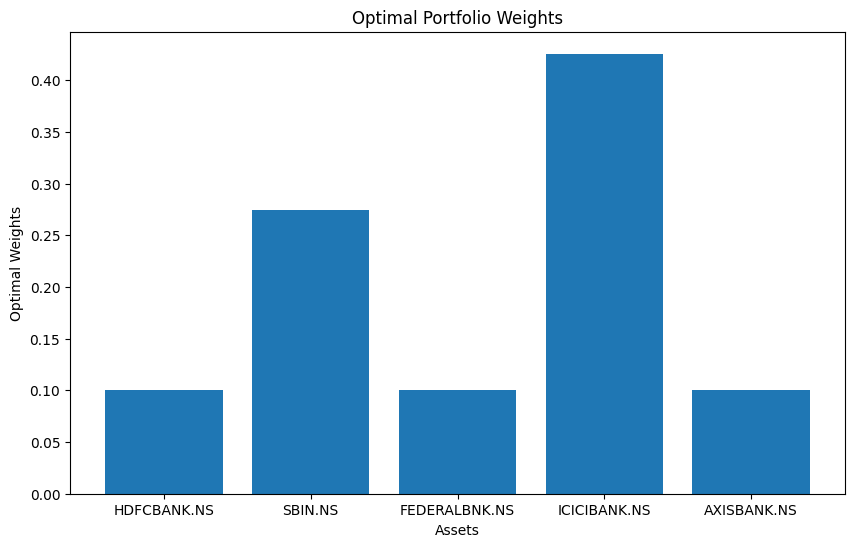

In [114]:
import matplotlib.pyplot as plt

#Create a abar chart of the optimal weights
plt.figure(figsize = (10,6))
plt.bar(tickers, optimal_weights)

#Add labels and a title
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

#Display the chart
plt.show()